Descompresion de datos

In [54]:
import missingno as msno
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import re
from unidecode import unidecode
from pandas.api.types import CategoricalDtype



In [2]:
def descomprimir_zips_en_datos():
    """
    Descomprime todos los archivos ZIP encontrados en el directorio actual
    dentro de una subcarpeta llamada 'datos'.
    """
    carpeta_destino = "datos"

    # Crear la carpeta 'datos' si no existe
    if not os.path.exists(carpeta_destino):
        os.makedirs(carpeta_destino)
        print(f"Carpeta '{carpeta_destino}' creada.")

    # Obtener una lista de todos los archivos en el directorio actual
    archivos_en_directorio = os.listdir('.')

    # Filtrar solo los archivos .zip
    archivos_zip = [f for f in archivos_en_directorio if f.endswith('.zip')]

    if not archivos_zip:
        print("No se encontraron archivos ZIP en el directorio actual.")
        return

    print(f"Archivos ZIP encontrados: {archivos_zip}")

    for archivo_zip in archivos_zip:
        ruta_completa_zip = os.path.join('.', archivo_zip)
        try:
            with zipfile.ZipFile(ruta_completa_zip, 'r') as zip_ref:
                zip_ref.extractall(os.path.join('.', carpeta_destino))
            print(f"'{archivo_zip}' descomprimido exitosamente en '{carpeta_destino}'.")
        except zipfile.BadZipFile:
            print(f"Error: '{archivo_zip}' no es un archivo ZIP válido o está corrupto.")
        except Exception as e:
            print(f"Ocurrió un error al descomprimir '{archivo_zip}': {e}")

descomprimir_zips_en_datos()

Archivos ZIP encontrados: ['estadisticas_normales_9120.zip', 'Registro_temperaturas-05072025.zip']
'estadisticas_normales_9120.zip' descomprimido exitosamente en 'datos'.
'Registro_temperaturas-05072025.zip' descomprimido exitosamente en 'datos'.


In [55]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

nombre_excel = "Estadísticas normales Datos abiertos 1991-2020.xlsx"
ruta_completa = os.path.join('datos', nombre_excel)

if not os.path.exists(ruta_completa):
    print(f"Error: El archivo '{ruta_completa}' no se encontró. Asegúrate de que el archivo ZIP se descomprimió correctamente y el archivo .xlsx está en la carpeta 'datos'.")
else:
    print(f"Intentando cargar '{nombre_excel}' sin especificar 'header' inicialmente para inspeccionar...")
    try:
        # Cargar sin especificar header para ver el raw data y encontrar la fila correcta
        df = pd.read_excel(ruta_completa, header=None)
        print(df.head())
        df.info()
        header_row_index = -1
        for i in range(min(10, len(df))):
            row_as_str = df.iloc[i].astype(str).str.lower()
            if ('estación' in row_as_str.values and 'valor medio de' in row_as_str.values):
                header_row_index = i
                break

        if header_row_index != -1:
            print(f"\n¡Encabezado detectado en la fila (0-indexada): {header_row_index}!")
            print(f"Las columnas en esa fila son: {df.iloc[header_row_index].tolist()}")
    except Exception as e:
        print(f"Ocurrió un error al intentar la carga inicial para depuración: {e}")
        

df = pd.read_excel(ruta_completa, header=header_row_index)
df_largo = df.melt(
    id_vars=['Estación', 'Valor Medio de'],
    var_name='Mes',
    value_name='Valor'
)

# --- Limpieza de Nombres y Caracteres Especiales ---

# 1. Renombrar las variables a un formato limpio (sin espacios ni símbolos)
mapa_nombres = {
    'Temperatura (°C)': 'temperatura_c',
    'Temperatura máxima (°C)': 'temperatura_maxima_c',
    'Temperatura mínima (°C)': 'temperatura_minima_c',
    'Humedad relativa (%)': 'humedad_relativa_porcentaje',
    'Velocidad del Viento (km/h) (2011-2020)': 'velocidad_viento_kmh',
    'Nubosidad total (octavos)': 'nubosidad_octavos',
    'Precipitación (mm)': 'precipitacion_mm',
    'Frecuencia de días con Precipitación superior a 1.0 mm': 'frecuencia_dias_precipitacion_gt_1mm'
}
df_largo['Variable'] = df_largo['Valor Medio de'].replace(mapa_nombres)
df_largo = df_largo.drop(columns=['Valor Medio de'])


# 2. Función para limpiar texto (quitar acentos, convertir a minúsculas, etc.)
def limpiar_texto(texto):
    if not isinstance(texto, str):
        return texto
    # Quita acentos y caracteres especiales (ej: á -> a)
    limpio = unidecode(texto)
    # Reemplaza espacios y guiones con guion bajo
    limpio = re.sub(r'[\s-]+', '_', limpio)
    # Quita cualquier caracter que no sea letra, número o guion bajo
    limpio = re.sub(r'[^\w]', '', limpio)
    return limpio.lower()


# 3. Aplicar la limpieza a las columnas de texto
df_largo['Estación'] = df_largo['Estación'].apply(limpiar_texto)
df_largo['Mes'] = df_largo['Mes'].apply(limpiar_texto)

# 4. Procesamiento final de valores
df_largo['Valor'] = pd.to_numeric(df_largo['Valor'], errors='coerce')


# --- Creación del DataFrame Final y Conteo de Nulos ---
columnas_ordenadas = ['Estación', 'Variable', 'Mes', 'Valor']
df_final = df_largo[columnas_ordenadas].copy()


# 1. Definir el orden correcto de los meses
meses_ordenados = [
    'ene', 'feb', 'mar', 'abr', 'may', 'jun',
    'jul', 'ago', 'sep', 'oct', 'nov', 'dic'
]

# 2. Crear el tipo de dato Categórico con el orden definido
tipo_mes_categorico = CategoricalDtype(categories=meses_ordenados, ordered=True)

# 3. Aplicar el nuevo tipo a la columna 'Mes'
df_final['Mes'] = df_final['Mes'].astype(tipo_mes_categorico)

# 4. Verificar el cambio en los tipos de datos
print("Tipos de datos después de la corrección:")
print(df_final.dtypes)
# --- Resultados ---
print("--- DataFrame Final (Transformado y Limpio) ---")
print(df_final.head(10))

print("\n--- Verificación de Nombres Limpios en Columnas ---")
print("Estaciones:", df_final['Estación'].unique()[:5])
print("Variables:", df_final['Variable'].unique())
print("Meses:", df_final['Mes'].unique())

# --- Aquí está el conteo de valores nulos ---
print("\n--- Conteo de Valores Nulos por Columna ---")
print(df_final.isnull().sum())


Intentando cargar 'Estadísticas normales Datos abiertos 1991-2020.xlsx' sin especificar 'header' inicialmente para inspeccionar...
                                                  0               1    2    3    4    5    6    7    8    9    10   11   12   13
0  Estadísticas Climatológicas Normales - período...             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
1  Se deja constancia que la información vertida ...             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2                                                NaN             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
3                                                NaN             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
4                                           Estación  Valor Medio de  Ene  Feb  Mar  Abr  May  Jun  Jul  Ago  Sep  Oct  Nov  Dic
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 14 

In [52]:
df_final.isnull()  # DataFrame booleano
df_final.isna().sum() 
print(df_final.isna().mean().round(4)*100)
print("------------------------------------------------")
print(f"Columnas del dataframe:\n{df_final.dtypes}\n") 

Estación    0.00
Variable    0.00
Mes         0.00
Valor       9.07
dtype: float64
------------------------------------------------
Columnas del dataframe:
Estación     object
Variable     object
Mes          object
Valor       float64
dtype: object



/tmp/ipykernel_17892/429308884.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivoted = df_final.pivot_table(


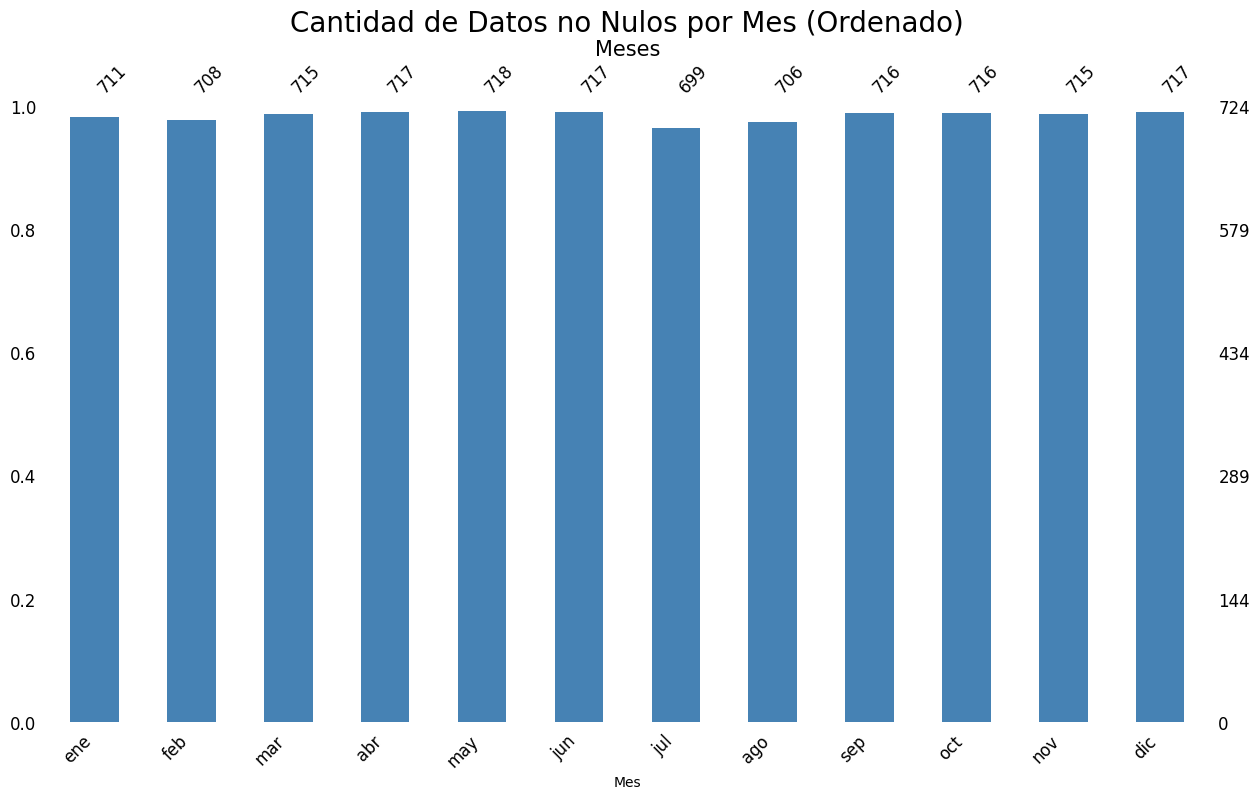

In [56]:
# Pivotear el DataFrame (los meses quedarán en orden alfabético)
df_pivoted = df_final.pivot_table(
    index=['Estación', 'Variable'],
    columns='Mes',
    values='Valor'
)

# Generar el gráfico con el DataFrame ya ordenado
msno.bar(df_pivoted, fontsize=12, figsize=(15, 8), color='steelblue')

# 5. Añadir título y mostrar el gráfico
plt.title('Cantidad de Datos no Nulos por Mes (Ordenado)', fontsize=20)
plt.xlabel('Meses', fontsize=15)
plt.ylabel('Observaciones no nulas', fontsize=15)
plt.show()


<Axes: >

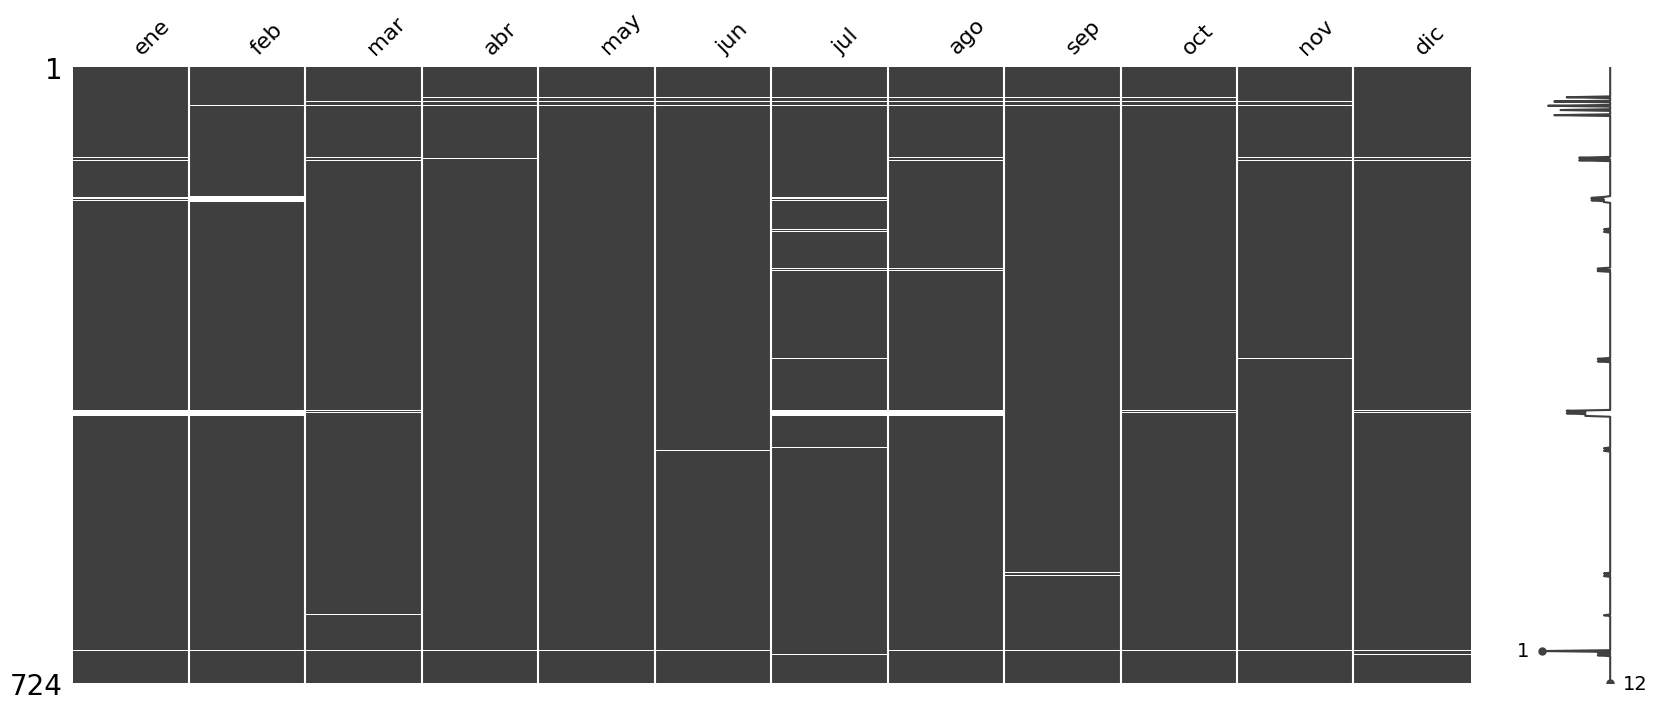

In [57]:
msno.matrix(df_pivoted, figsize=(20,8))

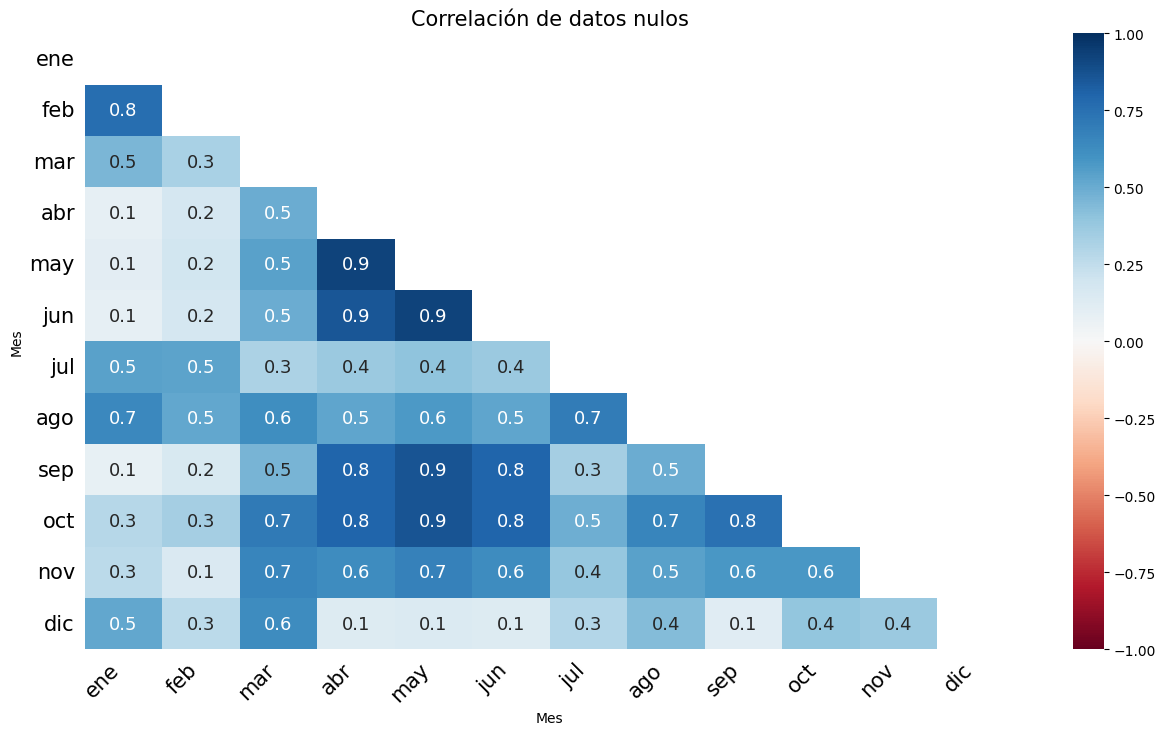

In [58]:
msno.heatmap(df_pivoted, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

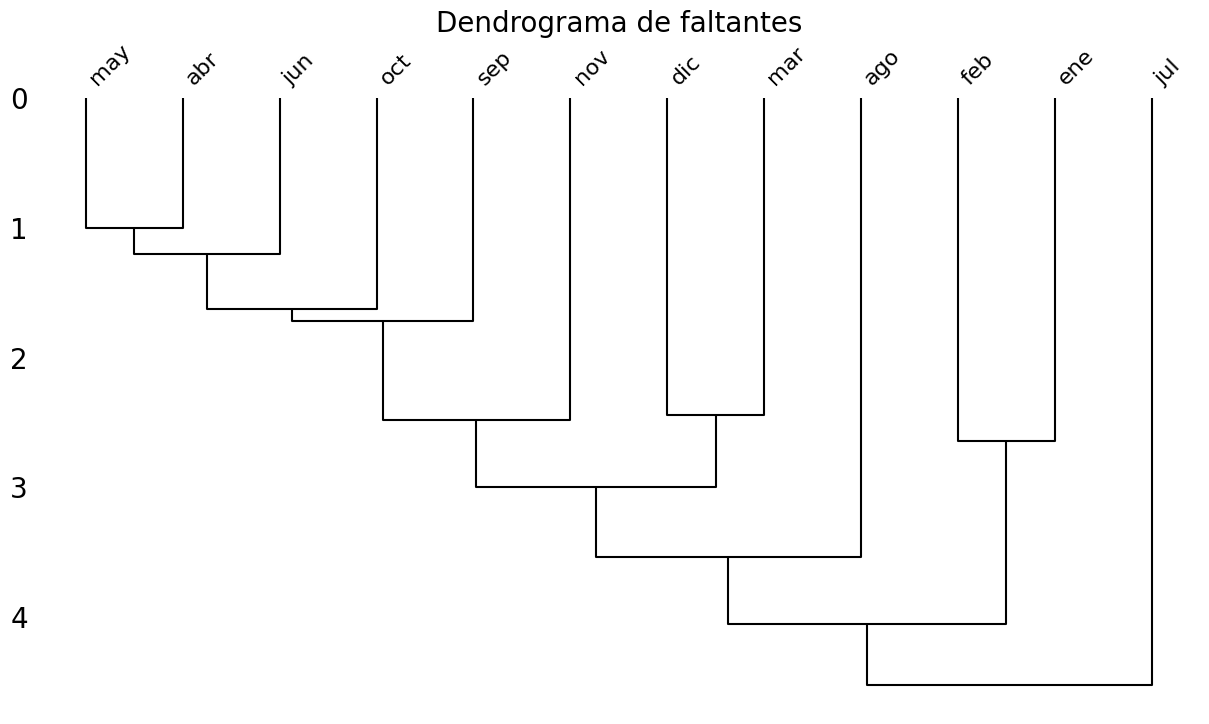

In [59]:
msno.dendrogram(df_pivoted, figsize=(15,8))
plt.title('Dendrograma de faltantes', fontsize=20)
plt.show()

In [60]:
print("Cantidad de datos duplicados:", df_pivoted.duplicated().sum())

Cantidad de datos duplicados: 5
